In [1]:
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import string
import re

In [3]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [4]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

In [5]:
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

#### Directories

In [6]:
proj_dir = Path().absolute().parents[0]
data_dir = Path(proj_dir, 'data')

#### Read in data

In [7]:
reviews = pd.read_csv(Path(data_dir, 'raw', 'comcast_consumeraffairs_complaints.csv'))

In [8]:
reviews.head()

,author,posted_on,rating,text
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...


#### Plot ratings

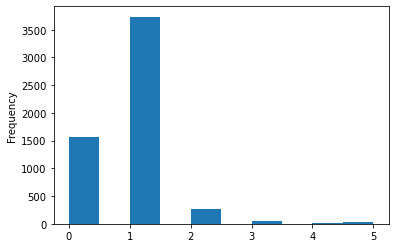

In [9]:
reviews['rating'].plot.hist()

#### Tokenize

In [10]:
spacy_nlp = spacy.load('en_core_web_sm')
stop_words = STOP_WORDS
punctuations = string.punctuation

In [11]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = spacy_nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Remove non words
    mytokens = [ word for word in mytokens if not re.search('[^A-Za-z]+', word) ]
    
    # return preprocessed list of tokens
    return mytokens

In [12]:
reviews['text'] = reviews['text'].astype('str')

In [13]:
reviews['tokenized'] = reviews['text'].apply(spacy_tokenizer)

In [14]:
# Create the Corpus
mydict = corpora.Dictionary(reviews['tokenized'])
mycorpus = [mydict.doc2bow(doc) for doc in reviews['tokenized']]

#### Build TFIDF

In [15]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    lowercase=False,
    token_pattern=None, 
    max_features = 1000)

bow = CountVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    lowercase=False,
    token_pattern=None, 
    max_features = 1000)

In [16]:
tfidf.fit(reviews['tokenized'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 1), norm='l2',
                preprocessor=<function dummy_fun at 0x000002A31F31D828>,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern=None,
                tokenizer=<function dummy_fun at 0x000002A31F31D828>,
                use_idf=True, vocabulary=None)

In [17]:
dtm = tfidf.transform(reviews['tokenized'])

In [18]:
dtm.shape

(5659, 1000)

In [19]:
bow.fit(reviews['tokenized'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=1000, min_df=1,
                ngram_range=(1, 1),
                preprocessor=<function dummy_fun at 0x000002A31F31D828>,
                stop_words=None, strip_accents=None, token_pattern=None,
                tokenizer=<function dummy_fun at 0x000002A31F31D828>,
                vocabulary=None)

In [20]:
dtm_bow = bow.transform(reviews['tokenized'])

In [21]:
dtm_bow.shape

(5659, 1000)

#### N topics

In [22]:
n_topics = 4

#### SVD

In [23]:
svd = TruncatedSVD(n_components=n_topics, random_state=123)
svd.fit(dtm)

TruncatedSVD(algorithm='randomized', n_components=4, n_iter=5, random_state=123,
             tol=0.0)

In [24]:
svd.transform(dtm).shape

(5659, 4)

In [25]:
svd.transform(dtm)

array([[ 0.1706074 , -0.06341649,  0.14356695, -0.01349218],
       [ 0.22751502, -0.02614652,  0.1363213 , -0.16063625],
       [ 0.32448441,  0.02455495,  0.05453409, -0.14600975],
       ...,
       [ 0.21117618,  0.07777216,  0.02831348,  0.08091577],
       [ 0.31708907,  0.1267114 ,  0.10109842, -0.01546386],
       [ 0.36399429, -0.17275366,  0.12730222, -0.12626078]])

In [26]:
svd.components_.shape

(4, 1000)

#### Create a topic object (similar to gensim)

In [27]:
def build_topic_object(components, terms):

    topics = []

    for i, comp in enumerate(components):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)
        topics = topics + [(i, sorted_terms)]

    return topics

In [28]:
def get_topic_words(topic_object):
    topics = []
    for topic_id, topic in topic_object:
        topic = [word for word, _ in topic]
        topics.append(topic)
    return topics

In [29]:
def get_topic_words_df(topic_object):  
    word_dict = {};
    for topic_id, topic in topic_object:
        topic = [word for word, _ in topic]
        word_dict['Topic # ' + '{:02d}'.format(topic_id + 1)] = topic
    return pd.DataFrame(word_dict);

In [30]:
svd_topics = build_topic_object(svd.components_, tfidf.get_feature_names())

In [31]:
# svd_topics

In [32]:
svd_topics_words = get_topic_words(svd_topics)

In [33]:
# svd_topics_words

In [34]:
get_topic_words_df(svd_topics).head(10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,service,bill,internet,box
1,comcast,month,channel,cable
2,tell,charge,speed,channel
3,bill,pay,tv,tell
4,time,fee,cable,come
5,customer,payment,box,charge
6,internet,account,month,bill
7,month,credit,price,tv
8,phone,contract,year,tech
9,cable,year,high,hd


#### NMF

In [35]:
nmf = NMF(n_components=n_topics, random_state=123)
nmf.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=123, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [36]:
nmf.transform(dtm).shape

(5659, 4)

In [37]:
nmf.transform(dtm)

array([[0.00670258, 0.        , 0.0452962 , 0.04051336],
       [0.        , 0.        , 0.10057605, 0.        ],
       [0.00885555, 0.02514862, 0.09499131, 0.00089395],
       ...,
       [0.01286592, 0.047012  , 0.00410802, 0.03672068],
       [0.        , 0.05903012, 0.06014462, 0.02924625],
       [0.05156266, 0.        , 0.08410909, 0.01286809]])

In [38]:
nmf.components_.shape

(4, 1000)

In [39]:
nmf_topics = build_topic_object(nmf.components_, tfidf.get_feature_names())

In [40]:
# nmf_topics

In [41]:
nmf_topics_words = get_topic_words(nmf_topics)

In [42]:
# nmf_topics_words

In [43]:
get_topic_words_df(nmf_topics).head(10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,day,bill,service,box
1,tell,month,internet,cable
2,come,charge,comcast,channel
3,phone,pay,customer,tv
4,tech,account,speed,hd
5,time,tell,company,digital
6,technician,comcast,year,watch
7,appointment,credit,bad,dvr
8,work,payment,time,comcast
9,hour,fee,use,pay


#### LDA

In [44]:
lda = LatentDirichletAllocation(n_components=n_topics, random_state=123)
lda.fit(dtm_bow)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=None,
                          perp_tol=0.1, random_state=123, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [45]:
lda.transform(dtm_bow).shape

(5659, 4)

In [46]:
lda.transform(dtm_bow)

array([[0.96894513, 0.01054846, 0.01051107, 0.00999535],
       [0.00922321, 0.57642932, 0.40511411, 0.00923336],
       [0.00413   , 0.98741384, 0.00433265, 0.0041235 ],
       ...,
       [0.66132733, 0.00301236, 0.00290671, 0.3327536 ],
       [0.00432448, 0.5854858 , 0.00414237, 0.40604735],
       [0.11193533, 0.00223385, 0.88361188, 0.00221893]])

In [47]:
lda.components_.shape

(4, 1000)

In [48]:
lda_topics = build_topic_object(lda.components_, bow.get_feature_names())

In [49]:
lda_topics_words = get_topic_words(lda_topics)

In [50]:
get_topic_words_df(lda_topics).head(10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,comcast,service,comcast,bill
1,cable,comcast,service,comcast
2,box,customer,internet,service
3,service,month,time,tell
4,tell,internet,phone,pay
5,come,tell,day,charge
6,work,time,work,month
7,tv,year,problem,account
8,time,company,tell,credit
9,day,pay,technician,receive


#### Check cases

In [51]:
case = 0

In [52]:
reviews['text'][case]

"I used to love Comcast. Until all these constant updates. My internet and cable crash a lot at night, and sometimes during the day, some channels don't even work and on demand sometimes don't play either. I wish they will do something about it. Because just a few mins ago, the internet have crashed for about 20 mins for no reason. I'm tired of it and thinking about switching to Wow or something. Please do not get Xfinity."

In [53]:
# pd.DataFrame(nmf.transform(dtm)).apply(lambda x: x / x.sum(), axis=1).iloc[case, :]
pd.DataFrame(lda.transform(dtm_bow)).apply(lambda x: x / x.sum(), axis=1).iloc[case, :]

0    0.968945
1    0.010548
2    0.010511
3    0.009995
Name: 0, dtype: float64

In [54]:
# np.argwhere(np.argmax(nmf.transform(dtm), axis=1) == 5)
np.argwhere(np.argmax(lda.transform(dtm_bow), axis=1) == 2)

array([[  11],
       [  13],
       [  19],
       ...,
       [5648],
       [5649],
       [5658]], dtype=int64)

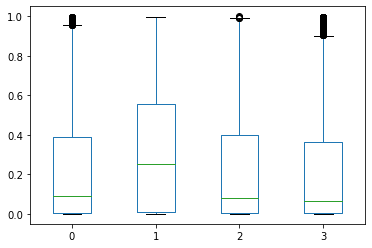

In [55]:
# pd.DataFrame(nmf.transform(dtm)).apply(lambda x: x / x.sum(), axis=1).plot.box()
pd.DataFrame(lda.transform(dtm_bow)).apply(lambda x: x / x.sum(), axis=1).plot.box()

#### test coherence

In [56]:
svd_cm = CoherenceModel(topics=svd_topics_words, corpus=mycorpus, dictionary=mydict, coherence='u_mass')
svd_cm.get_coherence()  # get coherence value

-1.5928454256344176

In [57]:
nmf_cm = CoherenceModel(topics=nmf_topics_words, corpus=mycorpus, dictionary=mydict, coherence='u_mass')
nmf_cm.get_coherence()  # get coherence value

-1.2847139629886601

In [58]:
lda_cm = CoherenceModel(topics=lda_topics_words, corpus=mycorpus, dictionary=mydict, coherence='u_mass')
lda_cm.get_coherence()  # get coherence value

-1.2026547988981917

In [59]:
svd_cm = CoherenceModel(topics=svd_topics_words, corpus=mycorpus, texts = reviews['tokenized'].tolist(), dictionary=mydict, coherence='c_uci')
svd_cm.get_coherence()  # get coherence value

0.1431856973639583

In [60]:
nmf_cm = CoherenceModel(topics=nmf_topics_words, corpus=mycorpus, texts = reviews['tokenized'].tolist(), dictionary=mydict, coherence='c_uci')
nmf_cm.get_coherence()  # get coherence value

0.17732895811273391

In [61]:
lda_cm = CoherenceModel(topics=lda_topics_words, corpus=mycorpus, texts = reviews['tokenized'].tolist(), dictionary=mydict, coherence='c_uci')
lda_cm.get_coherence()  # get coherence value

0.02658839305005535

#### Tune number of topics for NMF

In [62]:
# Collect the number of topics x coherence score
coherence_df = pd.DataFrame(columns=['Topics', 'Score'])

In [63]:
topics = []
score = []

for i in range(2, 20):
    
    # Fit lda
    lda = LatentDirichletAllocation(n_components=i, random_state=123)
    lda.fit(dtm_bow)
    
    # Get topic words
    lda_topics = build_topic_object(lda.components_, bow.get_feature_names())
    lda_topics_words = get_topic_words(lda_topics)
    
    # Get coherence
#     lda_cm = CoherenceModel(topics=lda_topics_words, corpus=mycorpus, dictionary=mydict, coherence='u_mass')
    lda_cm = CoherenceModel(topics=lda_topics_words, corpus=mycorpus, texts = reviews['tokenized'].tolist(), dictionary=mydict, coherence='c_v')
    print(lda_cm.get_coherence())  # get coherence value
    
    topics = topics + [i]
    score = score + [lda_cm.get_coherence()]

coherence_df = pd.DataFrame({'Topics':topics, 'Score':score})

0.368018027150949
0.3567886431321073
0.3686275602392247
0.3674498282797788
0.3818881188588095
0.3762613568978908
0.38910364129169006
0.40458721219452
0.39830148565537715
0.3978758165622825
0.37930273933216285
0.37997595547526386
0.39201336879829424
0.39009791024701734
0.3879765854694484
0.3855612449582684
0.39171189972640286
0.38599344360197624


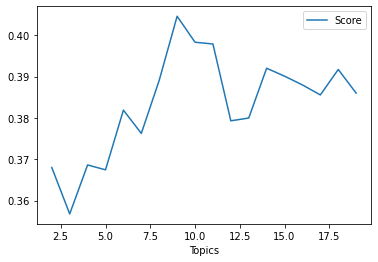

In [64]:
coherence_df.plot.line(x = 'Topics', y = 'Score')

In [65]:
coherence_df

,Topics,Score
0,2,0.368018
1,3,0.356789
2,4,0.368628
3,5,0.367450
4,6,0.381888
5,7,0.376261
6,8,0.389104
7,9,0.404587
8,10,0.398301
9,11,0.397876
